In [1]:
import torch
import sys
import os
sys.path.append('../')
from DataType.ElectricField import ElectricField
from LightSource.Gaussian_beam import Guassian_beam
from Props.ASM_Prop import ASM_prop
from Props.RSC_Prop import RSC_prop
from Components.Thin_Lens import Thin_LensElement
from Components.Aperture import ApertureElement
from Components.QuantizedDOE import SoftGumbelQuantizedDOELayerv3 as SoftGumbelQuantizedDOELayer
from Components.QuantizedDOE import NaiveGumbelQuantizedDOELayer
from Components.QuantizedDOE import PSQuantizedDOELayer
from Components.QuantizedDOE import STEQuantizedDOELayer
from Components.QuantizedDOE import FullPrecisionDOELayer
from utils.Helper_Functions import normalize, DOE_xyz_cordinates_Generator
from utils.units import *
import numpy as np
import scipy.io
import time
import torch.nn as nn

from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

# 1. Create an Arguments Dictionary

In [2]:
class Args:
    def __init__(self):
        self.save_path = 'loss_landscape_results'  # Base path for saving loss landscape images
        self.ex_name = 'splitter_full'  # Type of Experiments
        self.xmin = -5    # Minimum value of x-coordinate
        self.xmax = 5     # Maximum value of x-coordinate
        self.xnum = 101    # Number of x-coordinate
        self.ymin = -5    # Minimum value of y-coordinate
        self.ymax = 5     # Maximum value of y-coordinate
        self.ynum = 101    # Number of y-coordinate
        self.save_imges = True
        self.surf_name = 'loss'    # The type of surface to plot
        self.vmin = 0.01        # Miminum value to map
        self.vmax = 1        # Maximum value to map
        self.vlevel = 0.1      # plot contours every vlevel

# Instantiate and use the Args class
args = Args()

save_path = os.path.join(args.save_path, args.ex_name) 
if not os.path.isdir(save_path):
    os.makedirs(save_path)

# 1. Define the DOE's parameters and optimization target

In [3]:
# Hologram parameters (high-temp resin)
epsilon = 2.66
tand = 0.03
    
input_field_shape = [100, 100]
input_dxy = 1 * mm
doe_shape = [100, 100]
doe_dxy = 1 * mm
    
    
c0 = 2.998e8
f2 = 300e9  # 0.3 THz

wavelengths = c0 / f2
#print("The number of wavelengths: " +  str(wavelengths.shape[0]))

# all parameters of DOE optimization
doe_params = {
    'doe_size': doe_shape,
    'doe_dxy' : doe_dxy,
    'doe_level': 4,
    'look_up_table': None,
    'num_unit': 2,
    'height_constraint_max': 1 * mm,
    'tolerance': 10 * um,  
    'material': [epsilon, tand]
}

optim_params = {
    'c_s': 100,   # a number to boost the score (higher more robust to gumbel noise)
    'tau_max': 2.5, # maximum value of tau
    'tau_min': 1.5  # minimum value of tau
}

In [4]:
def define_FoM(resolution, sampling_size, wavelength, focal_length, position):
    """
    Calculates the Full-width-at-half-maximum (FWHM) by the far-field diffraction limit
    and applies it to model the point spread function (PSF) as a Gaussian function, with consistent intensity across positions.
    
    Parameters:
        resolution (tuple): The resolution of the field in pixels (height, width).
        sampling_size (float): The physical size of each pixel, in meters.
        wavelength (float): The wavelength of the light, in meters.
        focal_length (float): The focal length of the optical system, in meters.
        position (tuple): The target position in the field, in meters (x, y).
        
    Returns:
        torch.Tensor: The calculated and normalized PSF as a 2D Gaussian function over the specified field.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    height, width = resolution
    Length_x = sampling_size * width
    Length_y = sampling_size * height
    
    effective_L = torch.sqrt(torch.tensor((Length_x ** 2 + Length_y ** 2), device=device))
    NA = torch.sin(torch.atan(effective_L / (2 * focal_length)))
    FWHM = wavelength / (2 * NA)
    
    x_grid, y_grid = torch.meshgrid(torch.linspace(-Length_x / 2, Length_x / 2, steps=width, device=device),
                                    torch.linspace(-Length_y / 2, Length_y / 2, steps=height, device=device))
    
    x_position, y_position = torch.tensor(position, device=device)
    
    # Calculate the Gaussian PSF
    PSF = torch.exp(-((x_grid - x_position) ** 2 + (y_grid - y_position) ** 2) / ((FWHM*2) ** 2))
    
    # Normalize the PSF such that its maximum value is 1
    
    return normalize(PSF.unsqueeze(0).unsqueeze(0))

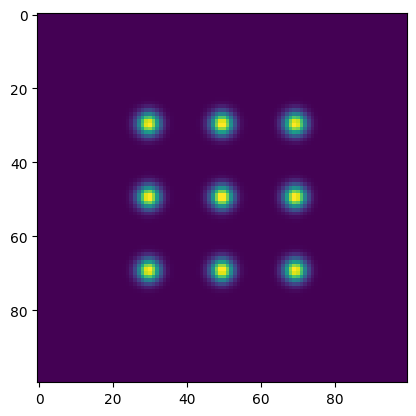

In [5]:
PSF_1 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[-20*mm, -20*mm])

PSF_2 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[20*mm, 20*mm])

PSF_3 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[-20*mm, 20*mm])

PSF_4 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[20*mm, -20*mm])

PSF_5 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[0*mm, 0*mm])

PSF_6 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[0*mm, -20*mm])

PSF_7 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[-20*mm, 0*mm])

PSF_8 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[0*mm, 20*mm])

PSF_9 = define_FoM(resolution=input_field_shape, sampling_size=input_dxy, 
                  wavelength=wavelengths, focal_length=200*mm, position=[20*mm, 0*mm])

target = PSF_1 + PSF_2 + PSF_3 + PSF_4 + PSF_5 + PSF_6 + PSF_7 + PSF_8 + PSF_9
plt.imshow(target[0, 0, :, :].cpu())

# 2. Define the System with FullPrecisionDOE

In [6]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=2, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = SoftGumbelQuantizedDOELayer(self.doe_params, self.optim_params) #NaiveGumbelQuantizedDOELayer(self.doe_params, self.optim_params) #SoftGumbelQuantizedDOELayer(self.doe_params, self.optim_params) #FullPrecisionDOELayer(self.doe_params)
        
        
        self.asm_prop3 = ASM_prop(z_distance=200 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        #field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        
        return final_field1

In [7]:
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [8]:
max_itrs = 6000

losses = []
itr_list = []
itr_to_save_plots = []

optimizer = torch.optim.AdamW(setup.parameters(), lr=0.02)
setup.cuda()
target = target.cuda()
photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    out_field = setup.forward(iter_frac=itr/max_itrs)
    out_amp = normalize(torch.abs(out_field.data)**2)
    loss = photometric_loss_fn(out_amp, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 1000 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths)
    
    if loss < best_loss:
        best_loss = loss
        best_field = out_field

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.0257517509162426
The iteration : 1000, Loss: 5.884071288164705e-05
The iteration : 2000, Loss: 3.0486606192425825e-05
The iteration : 3000, Loss: 6.0627095081144944e-05
The iteration : 4000, Loss: 0.00012056958075845614
The iteration : 5000, Loss: 7.123900286387652e-05
The iteration : 5999, Loss: 6.351386400638148e-05


In [10]:
from VisTools.directions import create_random_directions
from VisTools.calc_loss import calulate_single_element_loss_landscape
from VisTools.visualize import visualize_notebook

Create new 3d_sureface_file.h5
6.916592246852815e-05


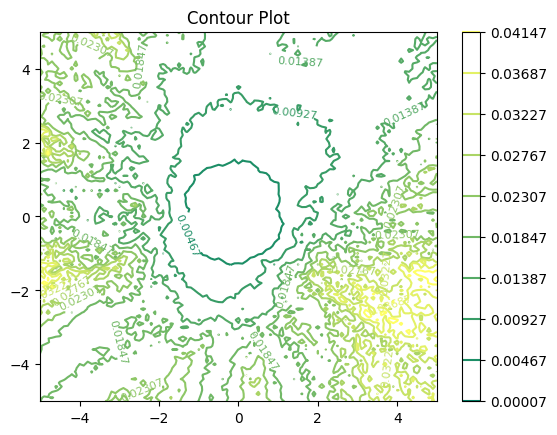

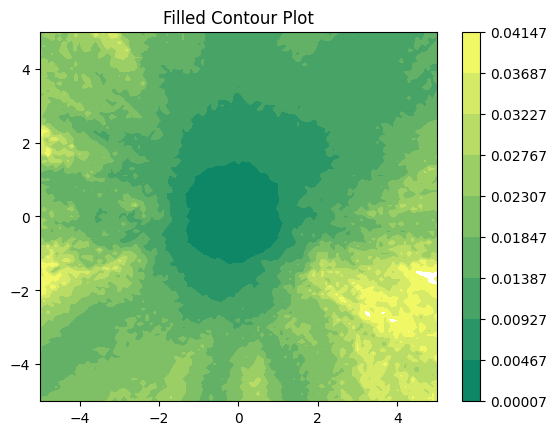

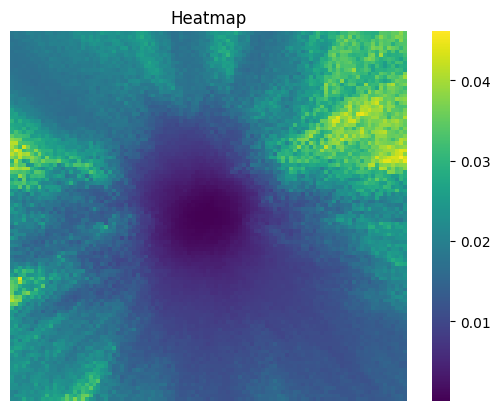

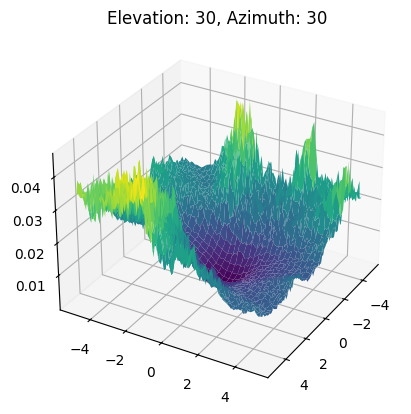

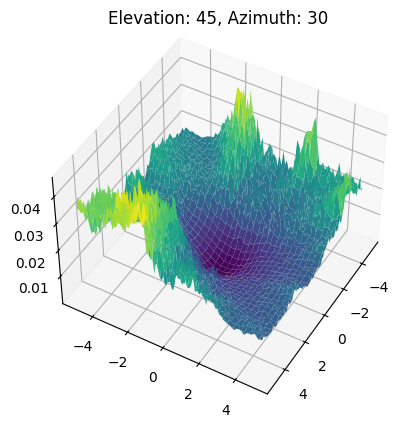

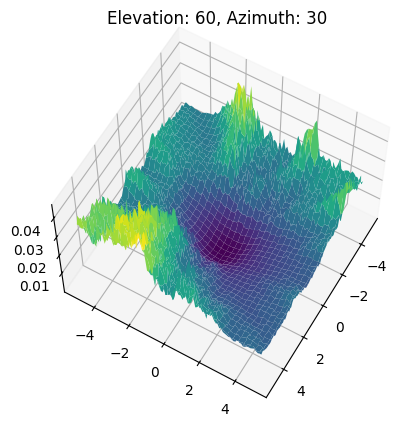

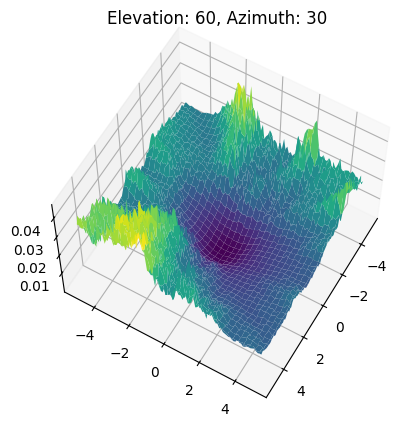

In [11]:
rand_directions = create_random_directions(setup)
surface_path = calulate_single_element_loss_landscape(args, model=setup, target=target, loss_f=photometric_loss_fn, directions=rand_directions, save_path=save_path)
visualize_notebook(args, save_path, surface_path)